# Lab 2

#### Alan Abadzic, John Girard, Eric Laigaie, Garrett Shankel

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("NY_Listings_Validated.csv")

### Data Preparation Part 1

In [2]:
# Create Grade Variable and Encode it
def categorise(row):  
    if row['Review Scores Rating'] > 89:
        return 1
    else:
        return 0
    return 'IDK'

df['Grade'] = df.apply(lambda row: categorise(row), axis=1)

df['Grade'].value_counts(normalize=True)

# Filter to only useful columns
data = df[['Host Response Rate', 'Host Is Superhost', 'Host total listings count', 'City', 'Room type',
          'Accommodates', 'Bathrooms', 'Bedrooms', 'Price', 'Minimum nights', 'Maximum nights', 'Availability 365',
          'Number of reviews', 'Reviews per month', 'Grade']]

In [3]:
# One-hot Encode
city_one_hot = pd.get_dummies(data['City'])
room_one_hot = pd.get_dummies(data['Room type'])

data = data.drop('City',axis = 1)
data = data.drop('Room type',axis = 1)

data = data.join(city_one_hot)
data = data.join(room_one_hot)


# Map boolean to integer
data["Host Is Superhost"] = data["Host Is Superhost"].astype(int)

In [4]:
# Scale Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

grade = data['Grade']
to_scale = data.drop("Grade", axis = 1)
cols = to_scale.columns

scaled = scaler.fit_transform(to_scale)

data = pd.DataFrame(scaled, columns = cols)
data['Grade'] = grade

In [5]:
data.head()

,Host Response Rate,Host Is Superhost,Host total listings count,Accommodates,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,...,Reviews per month,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,Grade
0,1.0,0.0,0.004086,0.000000,0.064516,0.000000,0.043043,0.000801,1.350418e-08,0.756164,...,0.072157,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,1.0,0.0,0.001021,0.000000,0.064516,0.000000,0.028028,0.000801,1.396984e-08,0.945205,...,0.062780,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,1.0,0.0,0.016343,0.200000,0.193548,0.076923,0.080080,0.001601,1.396984e-08,0.972603,...,0.156135,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.7,0.0,0.001021,0.200000,0.064516,0.000000,0.140140,0.000801,5.234033e-07,0.980822,...,0.027313,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,1.0,0.0,0.001021,0.066667,0.064516,0.000000,0.060060,0.000000,5.234033e-07,0.986301,...,0.150836,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### Data Preparation Part 2

Below is table that describes each variable in the dataset. This includes our two predictor variables, Price and Grade. Additionally, all variables are of type float64, except for the int64 Grade.

#### Variable Table
| Variable | Description |
| :-- | :-- |
| Host Response Rate | The rate that hosts respond to potential customers. |
| Host total listings count | The total number of airbnbs rentals the host owns. |
| Accommodates | The number of people this rental can accommodate. |
| Bathrooms | The number of bathrooms in this rental. |
| Bedrooms | The number of bedrooms in this rental. |
| Price | The base price for one night in this rental. |
| Minimum nights | The lowest amount of nights this rental can be booked for. |
| Maximum nights | The highest amount of nights this rental can be booked for. |
| Availability 365 | The proportion of nights in a year that the rental is available. |
| Reviews per month | The average number of reviews a rental receives in a month. |
| Host Is Superhost | One-hot variable: A "1" indicates the rental is operated by a Superhost. |
| Bronx | One-hot variable: A "1" indicates a Bronx-based rental. |
| Brooklyn | One-hot variable: A "1" indicates a Brooklyn-based rental. |
| Manhattan | One-hot variable: A "1" indicates a Manhattan-based rental. |
| Queens | One-hot variable: A "1" indicates a Queens-based rental. |
| Staten Island | One-hot variable: A "1" indicates a Staten Island-based rental. |
| Entire home/apt | One-hot variable: A "1" indicates this rental is an entire home or apartment. |
| Private room | One-hot variable: A "1" indicates this rental is a private room. |
| Shared room | One-hot variable: A "1" indicates this rental is a shared room. |
| Grade | One-hot variable: A "1" indicates this rental has a rating of .9 or more. |

### Modeling and Evaluation 1

#### Grade
To measure a model's performance when predicting Grade classification, we will use an F1 score. We decided on this for a few reasons. First, there isn't a large difference in costs between a false negative and false positive. In the case of a false negative, customers will likely get a rental that exceeds their expectations. For a false positive, customers will have to deal with a worse rental than they might be expecting, but this rental could still has a passing review grade (70+). Additionally, the inbalanced class distribution (67% A's, 33% Non-A's) leads us to use F1 instead of plain accuracy due to F1's strength when dealing with unbalanced classes.

#### Price
To measure a model's performance when predicting Price, we will use mean absolute percent error (MAPE). This option works well because it preserves the scale of the data (as opposed to squaring the difference), and provides a percentage value that is easier to interpret than a dollar value.

### Modeling and Evaluation 2

#### Grade
On top of an 80% train, 20% test split, we will be using stratified 10-fold cross validation with grid search here. While non-stratified CV could also work, our imbalanced dataset (67% A's, 33% Non-A's) could yield folds of data that have very little Non-A's. Using stratification avoids this by holding these proportions constant across folds, leading to better training sets.

#### Price
On top of an 80% train, 20% test split, we will be using 10-fold cross validation with grid search here. We will not be using stratification because we're not dealing with inbalanced class labels that should be keep consistent. Since our response is continuous, we do not necessarily have to worry about certain outcomes not being selection for each fold.

In both cases, grid search helps us determine the best parameters.

### Modeling and Evaluation 3

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time

# Split data into train and test
train, test = train_test_split(data, test_size=0.2)
train_y = train['Grade']
train_x = train.drop('Grade', axis=1)
test_y = train['Grade']
test_x = train.drop('Grade', axis=1)

#### Grade : Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
# Make classifier
dt_clf = DecisionTreeClassifier()

# Parameter Grid
parameters = {'max_depth':(5, 10), 'min_samples_split':(2, 5, 10), 'splitter':('best', 'random')}

# Make GridSearch - inputting a cv value toggles stratification on
dt_cv = GridSearchCV(estimator = dt_clf, param_grid = parameters, cv = 10)

# Fit
start = time.time()
dt_cv.fit(train_x,train_y)
end = time.time()

# Find best parameters and predict on them
best_parameters = dt_cv.best_params_
preds = dt_cv.predict(test_x)
print("F1 Score for Random Forest: " + str(round(f1_score(test_y, preds)*100,2)) + "%")
print("Time Elapsed: " + str(round(end-start,2)))
print("Best Parameters: " + str(best_parameters))

F1 Score for Random Forest: 88.48%
Time Elapsed: 12.42
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'splitter': 'best'}


#### Grade : Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter = 100000)

parameters = {'C':(1,10,100), 'solver':('lbfgs','saga')}
lr_cv = GridSearchCV(estimator = lr_clf, param_grid = parameters, cv = 10)
start = time.time()
lr_cv.fit(train_x,train_y)
end = time.time()

best_parameters = lr_cv.best_params_
preds = lr_cv.predict(test_x)
print("F1 Score for Logistic Regression: " + str(round(f1_score(test_y, preds)*100,2)) + "%")
print("Time Elapsed: " + str(round(end-start,2)))
print("Best Parameters: " + str(best_parameters))

F1 Score for Logistic Regression: 78.5%
Time Elapsed: 133.04
Best Parameters: {'C': 10, 'solver': 'saga'}


#### Grade : KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

parameters = {'n_neighbors':(3,5,7), 'algorithm':('auto','kd_tree')}
knn_cv = GridSearchCV(estimator = knn_clf, param_grid = parameters, cv = 10)
start = time.time()
knn_cv.fit(train_x,train_y)
end = time.time()

best_parameters = knn_cv.best_params_
preds = knn_cv.predict(test_x)
print("F1 Score for KNN: " + str(round(f1_score(test_y, preds)*100,2)) + "%")
print("Time Elapsed: " + str(round(end-start,2)))
print("Best Parameters: " + str(best_parameters))

F1 Score for KNN: 85.08%
Time Elapsed: 250.18
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7}


In [10]:
# Reset Price column
data['Price'] = df['Price']

# Split data into train and test
train, test = train_test_split(data, test_size=0.2)
train_y = train['Price']
train_x = train.drop('Price', axis=1)
test_y = train['Price']
test_x = train.drop('Price', axis=1)

#### Price : Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_absolute_error
linr_clf = LinearRegression()

parameters = {'fit_intercept':(True,False)}
linr_cv = GridSearchCV(estimator = linr_clf, param_grid = parameters, cv = 10)
start = time.time()
linr_cv.fit(train_x,train_y)
end = time.time()

best_parameters = linr_cv.best_params_
preds = linr_cv.predict(test_x)
check_MAPE = pd.DataFrame()
check_MAPE['real'], check_MAPE['preds'] = test_y, preds
check_MAPE['diff'] = abs(check_MAPE['preds'] - check_MAPE['real']) / check_MAPE['real']
check_MAPE = check_MAPE.replace(np.inf, np.nan)
print("Mean Absolute Percent Error for Linear Regression: " + str(round((check_MAPE['diff'].mean())*100,2)) + '%')
print("Time Elapsed: " + str(round(end-start,2)))
print("Best Parameters: " + str(best_parameters))

Mean Absolute Percent Error for Linear Regression: 39.17%
Time Elapsed: 0.68
Best Parameters: {'fit_intercept': False}


#### Price : Elastic Net Regression

In [12]:
from sklearn.linear_model import ElasticNet

el_clf = ElasticNet()

parameters = {'l1_ratio':(.25,.5,.75),'alpha':(.1,1,10),'selection':('random','cyclic')}
el_cv = GridSearchCV(estimator = el_clf, param_grid = parameters, cv = 10)
start = time.time()
el_cv.fit(train_x,train_y)
end = time.time()

best_parameters = el_cv.best_params_
preds = el_cv.predict(test_x)
check_MAPE = pd.DataFrame()
check_MAPE['real'], check_MAPE['preds'] = test_y, preds
check_MAPE['diff'] = abs(check_MAPE['preds'] - check_MAPE['real']) / check_MAPE['real']
check_MAPE = check_MAPE.replace(np.inf, np.nan)
print("Mean Absolute Percent Error for Elastic Net Regression: " + str(round((check_MAPE['diff'].mean())*100,2)) + '%')
print("Time Elapsed: " + str(round(end-start,2)))
print("Best Parameters: " + str(best_parameters))

Mean Absolute Percent Error for Elastic Net Regression: 41.36%
Time Elapsed: 5.82
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.75, 'selection': 'random'}


#### Price : Random Forest Regression

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_clf = RandomForestRegressor()

parameters = {'max_depth':(5, 10), 'bootstrap':(True, False)}
rf_cv = GridSearchCV(estimator = rf_clf, param_grid = parameters, cv = 10)
start = time.time()
rf_cv.fit(train_x,train_y)
end = time.time()

best_parameters = rf_cv.best_params_
preds = rf_cv.predict(test_x)
check_MAPE = pd.DataFrame()
check_MAPE['real'], check_MAPE['preds'] = test_y, preds
check_MAPE['diff'] = abs(check_MAPE['preds'] - check_MAPE['real']) / check_MAPE['real']
check_MAPE = check_MAPE.replace(np.inf, np.nan)
print("Mean Absolute Percent Error for Random Forest Regression: " + str(round((1 - check_MAPE['diff'].mean())*100,2)) + '%')
print("Time Elapsed: " + str(round(end-start,2)))
print("Best Parameters: " + str(best_parameters))

Mean Absolute Percent Error for Random Forest Regression: 67.51%
Time Elapsed: 278.97
Best Parameters: {'bootstrap': True, 'max_depth': 10}


### Modeling and Evaluation 4

### Modeling and Evaluation 5

| Model Name | Predicting | Accuracy Metric | Accuracy Score | Time (s) |
| :-- | :-- | :-- | :-: | :-: |
| Decision Tree | Grade | F1 Score | 88.48% | 12 |
| Logistic Regression | Grade | F1 Score | 78.50% | 133 |
| KNN | Grade | F1 Score | 85.08% | 250 |
| Linear Regression | Price | MAPE | 39.17% | 1 |
| Elastic Net Regression | Price | MAPE | 41.36% | 6 |
| Random Forest | Price | MAPE | 67.51% | 279 |

*Note the Accuracy Score column: For F1, we want a higher number. For MAPE, we want a lower number.*


#### Accuracy

For the models predicting Grade classification, the decision tree model is the best performing option by a good margin. To prove this, we have calculated 99% confidence intervals for each model's F1 score and plotted them below.

For the Price models, the battle for best accuracy performance is much closer. Again, we calculated 99% confidence intervals for the MAPE and plotted them. From that chart, we know that the linear regression model's interval slightly beats out the elastic net model.

To calculate these confidence intervals, we found the variances for each error and applied the 2.576 multiplier to find the upper and lower bounds of each interval.

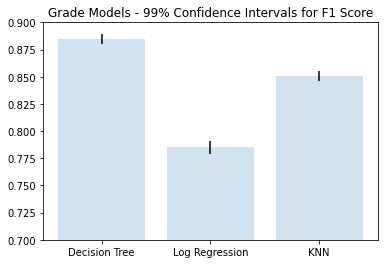

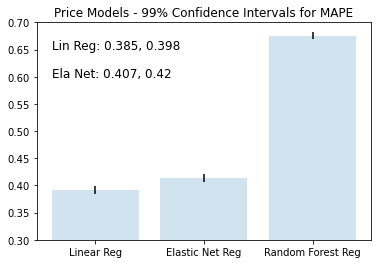

In [77]:
# Calculating 95% Confidence Intervals for Model Pairs
import math
import matplotlib.pyplot as plt

dt_var = ((1 - .8848) * .8848) / len(test_y)
lr_var = ((1 - .7850) * .7850) / len(test_y)
kn_var = ((1 - .8508) * .8508) / len(test_y)
dt_ci = ((.8848) - (2.576*math.sqrt(dt_var)),(.8848) + (2.576*math.sqrt(dt_var)))
lr_ci = ((.785) - (2.576*math.sqrt(lr_var)),(.785) + (2.576*math.sqrt(lr_var)))
kn_ci = ((.8508) - (2.576*math.sqrt(kn_var)),(.8508) + (2.576*math.sqrt(kn_var)))

# reference: https://stackoverflow.com/questions/42919936/hard-coding-confidence-interval-as-whiskers-in-bar-plot
errors = [.8848, .785, .8508]
cis = [dt_ci,lr_ci,kn_ci]
y_r = [errors[i] - cis[i][1] for i in range(len(ci))]
plt.bar(range(len(errors)), errors, yerr=y_r, alpha=0.2, align='center')
plt.xticks(np.arange(3), ['Decision Tree', 'Log Regression', 'KNN'])
plt.ylim([.7, .9])
plt.title('Grade Models - 99% Confidence Intervals for F1 Score')
plt.show()

lr_var = ((1-.3917) * .3917) / len(test_y)
en_var = ((1-.4136) * .4136) / len(test_y)
rf_var = ((1-.6751) * .6751) / len(test_y)
lr_ci = ((.3917) - (2.576*math.sqrt(lr_var)),(.3917) + (2.576*math.sqrt(lr_var)))
en_ci = ((.4136) - (2.576*math.sqrt(en_var)),(.4136) + (2.576*math.sqrt(en_var)))
rf_ci = ((.6751) - (2.576*math.sqrt(rf_var)),(.6751) + (2.576*math.sqrt(rf_var)))
lr_str = "Lin Reg: " + str(round(lr_ci[0],3)) + ', ' + str(round(lr_ci[1],3))
en_str = "Ela Net: " + str(round(en_ci[0],3)) + ', ' + str(round(en_ci[1],3))

# reference: https://stackoverflow.com/questions/42919936/hard-coding-confidence-interval-as-whiskers-in-bar-plot
errors = [.3917, .4136, .6751]
cis = [lr_ci,en_ci,rf_ci]
y_r = [errors[i] - cis[i][1] for i in range(len(ci))]
plt.bar(range(len(errors)), errors, yerr=y_r, alpha=0.2, align='center')
plt.xticks(np.arange(3), ['Linear Reg', 'Elastic Net Reg', 'Random Forest Reg'])
plt.ylim([.30, .7])
plt.title('Price Models - 99% Confidence Intervals for MAPE')
plt.text(-.4, .65, lr_str, fontsize=12)
plt.text(-.4, .6, en_str, fontsize=12)
plt.show()

#### Interpretability

Across the board, regression models (especially linear) are typically easier to interpret because the user is given coefficients that are fairly intuitive. Therefore, the decision trees and KNN models are inherently less interpretable from a non-data scientist perspective.

#### Time

The KNN and Random Forest models took about four minutes each to train. This is vastly more time that the decision tree and linear regression / elastic net regression models, which took a handful of seconds each. However, this time difference is almost negligible if it's trained infrequently.

### Modeling and Evaluation 6

Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

WE DID SOMETHING VERY SIMILAR IN THE MINILAB. JUST NEED TO DO IT FOR THE BEST PRICE AND GRADE MODEL

### Deployment

#### End user value
When using our models we could figure out a price for the listing that would attract potential renters. With the rising costs of Airbnb's lately, and people turning back to using hotels, the owners of the rentals will want to ensure that their listings are generating revenue and not being ignored due to bad pricing points. This will serve the owner of the property immensely, because having an extra mortgage that is not being subsidized by income from renters can prove to be quite perilous.

For the renter, they will have security knowing that the pricing points that the Airbnb units are going for have been reasonably priced and within reason.

#### How to deploy this model within the application
We feel that once we have a lock on what the pricing point could/should be, the lister of the rental would be able to select a price using a sliding scale(dragging along a line to select a price). Listers of properties could utilize this scale in a manner similar to this:

A starting point on one side of the scale (left) where the price is lower so it would greatly appeal to users looking for a value listing.

On the other side of the scale (right) a higher price point listed that would garner more profit to the lister at the possible expense of not attracting a tenant. Ultimately it will be up to the lister of the property to select a price point that appeals to potential renters and a price that makes fiscal sense, we are simply giving them a good and believable range to list their property at.

If used properly, there could be an equilibrium met where the renter feels they are getting a fair price, and the lister feels that their property is fetching a fair market value.

#### What other data needs to be collected
Since our model is pretty heavily aimed at price, I think a good data point that would need to be collected would be the neighborghood. The price of the listing would probably be closely correlated to the neighborhood. People will pay more/less to stay at a listing in certain neighborhoods, so our pricing model needs to be looked at in the confines of what neighborhood the listing is in. I.E accurate pricing within each neighborhood.

One other big data point I think we should capture is how often listings are actually being used (the % of listings that are being used/the total amount of listings available). New York for example often has weekends where more people are staying in rental properties (Fashion Week, Tennis' US Open, NYC marathon, Super Bowl, etc..). Weekends like this are bound to capture more out of towners seeking temporary housing accomodations. Having an increase in demand will allow listers of properties to be able to charge more money for their listings.

#### How frequently should our data be updated
Paying attention to real estate is always a very active endeavor. With the nature of real estate being what it is, I feel that our data would need to be updated daily. New listings tend to pop up on Airbnb daily and it is important to note what prices those new properties are being rented out at. Updating the data daily will also allow Airbnb to have a more accurate handle on the demand surges. Having a accurate pricing point during these demand increases will allow the lister to feel that they are not losing out on potential money.

### Exceptional Work
In the above section above we used 10-fold cross validation gridsearch in our models for Grade and Price. Grid Search is used for most paramaters in ML problems. Using gridsearch we are able to automatically run through parameters that hypertune our model without having interference between iteration. Values such as ammenities cannot be calcualted easily, so using this function let us quantify a lot of columns within our data. Being able to put this into our models really strengthened our results in the end which are included up above in the model evaluation for part 3. We feel that our ability to classify the Grade and Price is more robust utilizing a grid search.